# Importing libraries

In [3]:
import pandas as pd
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, normalize
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Bidirectional, Dropout
from keras.optimizers import Adam

%matplotlib inline

tf.set_random_seed(1234)
np.random.seed(1234)

Using TensorFlow backend.


# Reading Data file

In [0]:
with gzip.open("mfcc_features.pkl", 'rb') as ifp:
    df = pickle.load(ifp)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


                                            Features                 Name Label  lengths
0  [[16.83934326211564, 7.122831080454019, -15.75...  Ses01M_impro01_F022   ang     1000
1  [[14.494079382110739, 7.730831222603203, -3.82...  Ses01M_impro01_M003   neu      246
2  [[12.031490986053488, -0.37954713964313613, -8...  Ses01M_impro01_M017   fru      272
3  [[13.346119672913716, -2.352727728420929, -3.3...  Ses01M_impro01_M016   fru      209
4  [[15.0055667757475, -24.48304889999013, -20.88...  Ses01M_impro01_M002   fru      309

Total Data size: 7379
Male Samples: 3911
Female Samples: 3468

Emotion-wise samples
ang: 1103
neu: 1707
fru: 1849
sad: 1084
exc: 1041
hap: 595


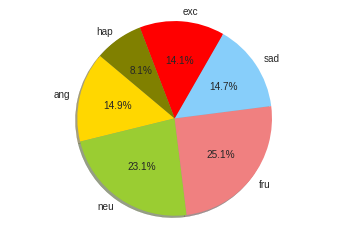

array(['ang', 'exc', 'fru', 'hap', 'neu', 'sad'], dtype=object)

In [5]:
pd.set_option('display.width', 100)
# print(df.head())

df.reset_index(inplace=True)
df.drop('index', inplace=True, axis=1)

male = 0
female = 0
        
for index, row in df.iterrows():
    if row['Name'][-4] == 'F':
        female +=1
    else:
        male +=1
    df.set_value(index, 'lengths', row['Features'].shape[0])
        
print(df.head())
        
print('\nTotal Data size:', df.shape[0])
print('Male Samples:', male)
print('Female Samples:', female)
print('\nEmotion-wise samples')

emo_name = []
emo_number = []
for i in df['Label'].unique():
    print('%s: %d' %(i, np.sum(df['Label'] == i)))
    emo_name.append(i)
    emo_number.append(np.sum(df['Label'] == i))
plt.pie(emo_number, labels=emo_name, colors=['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'olive'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()
    
le = LabelEncoder()
le.fit(df['Label'].values)
le.classes_

# Preparing Data

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_test, df_val = train_test_split(df_test, test_size=0.75, random_state=0)
print('training samples:', df_train.shape[0])
print('validation samples:', df_val.shape[0])
print('test samples:', df_test.shape[0])

training samples: 5903
validation samples: 1107
test samples: 369


# Bucket Iterator

In [0]:
class BucketedDataIterator():
    def __init__(self, df, num_buckets = 7):
        df = df.sort_values('lengths').reset_index(drop=True)
        self.size = len(df) / num_buckets
        self.dfs = []
        for bucket in range(num_buckets):
            self.dfs.append(df.loc[bucket*self.size: (bucket+1)*self.size - 1])
        self.num_buckets = num_buckets

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.shuffle()

        self.epochs = 0

    def shuffle(self):
        #sorts dataframe by sequence length, but keeps it random within the same length
        for i in range(self.num_buckets):
            self.dfs[i] = self.dfs[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0

    def next_batch(self, n):
        if np.any(self.cursor+n+1 > self.size):
            self.epochs += 1
            self.shuffle()

        i = np.random.randint(0,self.num_buckets)

        res = self.dfs[i].loc[self.cursor[i]:self.cursor[i]+n-1]
        self.cursor[i] += n

        # Pad sequences with 0s so they are all the same length
        maxlen = int(max(res['lengths']))
        
        x = np.zeros([n, maxlen, 32], dtype=np.float)
        for i, x_i in enumerate(x):
            x_i[:res['lengths'].values[i]] = res['Features'].values[i]

        return x, le.transform(res['Label'].values), res['lengths']

In [8]:
tr = BucketedDataIterator(df_train)
mini_batch = tr.next_batch(128)
X = mini_batch[0]
y = mini_batch[1]
seqlen = mini_batch[2]
print('X shape:', X.shape)
print('Target:', y[:5])
print('Sequence length:\n', seqlen[:5])

X shape: (128, 191, 32)
Target: [5 1 2 1 2]
Sequence length:
 0    124
1    149
2    177
3    167
4    169
Name: lengths, dtype: int64


# Tensorflow Models

In [0]:
import tensorflow as tf
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python.ops import rnn, rnn_cell
from tensorflow.contrib.rnn import stack_bidirectional_dynamic_rnn
import time

# some hyperparameters
init_epoch = 20
hm_epochs = 10
n_classes = 6
batch_size = 128
learning_rate = 0.001
num_mfcc_features = 32
rnn_size = 64
dropout = 0.8

tr_acc, te_acc, tr_loss, te_loss = [], [], [], []
tr_acc = np.load('temp_32_att_fc/tr_acc.npy')
tr_loss = np.load('temp_32_att_fc/tr_loss.npy')
te_acc = np.load('temp_32_att_fc/te_acc.npy')
te_loss = np.load('temp_32_att_fc/te_loss.npy')

# resets tensorflow graph
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

# model graph
def rnn_model():
    
    # resets the previous graph
    reset_graph()

    # defining placeholders
    x = tf.placeholder(tf.float32,[batch_size, None, num_mfcc_features])
    y = tf.placeholder(tf.int32, [batch_size])
    seq_length = tf.placeholder(tf.int32, [batch_size])
    keep_prob = tf.placeholder(tf.float32)
    phase = tf.placeholder(tf.bool)
    
    scale = tf.Variable(tf.ones([batch_size]))
    beta = tf.Variable(tf.zeros([batch_size]))
    pop_mean = tf.Variable(tf.zeros([batch_size]), trainable=False)
    pop_var = tf.Variable(tf.ones([batch_size]), trainable=False)
    epsilon = 1e-3
    decay = 0.999
    attn_length = 32
    num_layers = 2
  
    layer = {'weight1':tf.Variable(tf.random_normal([rnn_size*2, 128])),
            'bias1':tf.Variable(tf.random_normal([128])),
            'weight2':tf.Variable(tf.random_normal([128, n_classes])),
            'bias2':tf.Variable(tf.random_normal([n_classes]))}
    
    '''
    fw_cell = rnn_cell.BasicLSTMCell(rnn_size, state_is_tuple=True)
    bw_cell = rnn_cell.BasicLSTMCell(rnn_size, state_is_tuple=True)
    print(fw_cell.output_size, bw_cell.output_size)

    fw_cell = tf.contrib.rnn.AttentionCellWrapper(fw_cell, attn_length=attn_length, state_is_tuple=True)
    bw_cell = tf.contrib.rnn.AttentionCellWrapper(bw_cell, attn_length=attn_length, state_is_tuple=True)
    print(fw_cell.output_size, bw_cell.output_size)
    
    stacked_rnn_fw, stacked_rnn_bw = [], []
   
    for _ in range(num_layers):
        stacked_rnn_fw.append(fw_cell)
        stacked_rnn_bw.append(bw_cell)
        
    rnn_fw_cell = tf.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn_fw, state_is_tuple=True)
    rnn_bw_cell = tf.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn_bw, state_is_tuple=True)
    print(rnn_fw_cell.output_size, rnn_bw_cell.output_size)

    rnn_outputs, final_state_fw, final_state_bw = stack_bidirectional_dynamic_rnn([rnn_fw_cell], [rnn_bw_cell], x, dtype=tf.float32, sequence_length=seq_length)

    ''' 
    
    # multiple RNN layers 
    num_layers = 2
    stacked_rnn_fw, stacked_rnn_bw = [], []
    for _ in range(num_layers):
        stacked_rnn_fw.append(tf.contrib.rnn.AttentionCellWrapper(rnn_cell.BasicLSTMCell(rnn_size, state_is_tuple=True), attn_length=attn_length, state_is_tuple=True))
        stacked_rnn_bw.append(tf.contrib.rnn.AttentionCellWrapper(rnn_cell.BasicLSTMCell(rnn_size, state_is_tuple=True), attn_length=attn_length, state_is_tuple=True))
    cell_fw = tf.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn_fw, state_is_tuple=True)
    cell_bw = tf.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn_bw, state_is_tuple=True)
    rnn_outputs, final_state_fw, final_state_bw = stack_bidirectional_dynamic_rnn([cell_fw], [cell_bw], x, dtype=tf.float32, sequence_length=seq_length)

    '''
    # single RNN layer
    lstm_fw_cell = rnn_cell.BasicLSTMCell(rnn_size)
    lstm_bw_cell = rnn_cell.BasicLSTMCell(rnn_size)
    rnn_outputs, final_state_fw, final_state_bw = stack_bidirectional_dynamic_rnn([lstm_fw_cell], [lstm_bw_cell], x, dtype=tf.float32, sequence_length=seq_length)
    ''' 
  
    # batchnorm
    if phase==True:
        batch_mean, batch_var = tf.nn.moments(rnn_outputs,[0])
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            rnn_outputs = tf.nn.batch_normalization(rnn_outputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        rnn_outputs = tf.nn.batch_normalization(rnn_outputs, pop_mean, pop_var, beta, scale, epsilon)

    rnn_outputs = tf.nn.relu(rnn_outputs)
    rnn_outputs = tf.nn.dropout(rnn_outputs, keep_prob)
    
    # stacking the outputs of all time frames
    last_rnn_output = tf.gather_nd(rnn_outputs, tf.stack([tf.range(batch_size), seq_length-1], axis=1))
    
    # fully-connected layer
    fc = tf.add(tf.matmul(last_rnn_output, layer['weight1']), layer['bias1'])
    output = tf.add(tf.matmul(fc, layer['weight2']), layer['bias2'])
    
    # predicting labels
    preds = tf.nn.softmax(output)
    
    # calculating accuracy
    correct = tf.equal(tf.argmax(preds,1), tf.argmax(tf.one_hot(y,6),1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    # calculating loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=tf.one_hot(y,6)))

    # adding optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    return {'x': x, 'seqlen': seq_length, 'y': y, 'loss': cost, 'preds': preds, 'accuracy': accuracy, 'dropout': keep_prob, 'phase': phase, 'optimizer': optimizer}

def train_model(graph):
    
    with tf.Session() as sess:
                             
        sess.run(tf.global_variables_initializer())
        
        saver = tf.train.Saver()
        saver = tf.train.import_meta_graph('temp_32_att_fc/weights_epoch_{0}.ckpt.meta'.format(init_epoch))
        saver.restore(sess, 'temp_32_att_fc/weights_epoch_{0}.ckpt'.format(init_epoch))
        
        tr_acc = np.load('temp_32_att_fc/train_accuracy.npy')
        tr_loss = np.load('temp_32_att_fc/train_loss.npy')
        te_acc = np.load('temp_32_att_fc/test_accuracy.npy')
        te_loss = np.load('temp_32_att_fc/test_loss.npy')
        
        tr_acc, te_acc, tr_loss, te_loss = [], [], [], []

        tr = BucketedDataIterator(df_train, 7)
        te = BucketedDataIterator(df_val, 1)

        step, accuracy, loss = 0, 0, 0
        current_epoch = 0
        ep = False
        while current_epoch < hm_epochs:
            # for timing the epoch
            if ep==False:
                start_time = time.time()
                ep = True
            step += 1
            mini_batch = tr.next_batch(batch_size)
            _, accuracy_, loss_ = sess.run([graph['optimizer'], graph['accuracy'], graph['loss']], feed_dict = {graph['x']: mini_batch[0], 
                                      graph['y']: mini_batch[1],graph['seqlen']: mini_batch[2], graph['dropout']: dropout, graph['phase']: 1})
            accuracy += accuracy_
            loss += loss_ 
            
            if tr.epochs > current_epoch:
                ep = False
                current_epoch += 1
                tr_acc = np.append(tr_acc, accuracy/step)
                tr_loss = np.append(tr_loss, loss/step)
                step, accuracy, loss = 0, 0, 0

                #eval test set
                te_epoch = te.epochs
                while te.epochs == te_epoch:
                    step += 1
                    mini_batch = te.next_batch(batch_size)
                    accuracy_, loss_ = sess.run([graph['accuracy'], graph['loss']], feed_dict = {graph['x']: mini_batch[0], 
                                                 graph['y']: mini_batch[1], graph['seqlen']: mini_batch[2], graph['dropout']: 1, graph['phase']: 0})
                    accuracy += accuracy_
                    loss += loss_

                te_acc = np.append(te_acc, accuracy/step)
                te_loss = np.append(te_loss, loss/step)
                step, accuracy, loss = 0, 0, 0
                
                if current_epoch%5==0:
                    saver.save(sess, 'temp_32_att_fc/weights_epoch_{0}.ckpt'.format(current_epoch+init_epoch))
                    np.save('temp_32_att_fc/train_accuracy.npy', tr_acc)
                    np.save('temp_32_att_fc/train_loss.npy', tr_loss)
                    np.save('temp_32_att_fc/test_accuracy.npy', te_acc)
                    np.save('temp_32_att_fc/test_loss.npy', te_loss)
                    print('Weights saved.')
               
                end_time = time.time()
                print("Epoch: %d/%d - time: %.2fs\nloss: %0.4f - acc: %.4f - val_loss: %.4f - val_acc: %.4f\n" % (current_epoch+init_epoch, hm_epochs+init_epoch, end_time-start_time, tr_loss[-1], tr_acc[-1], te_loss[-1], te_acc[-1]))

    return tr_acc, tr_loss, te_acc, te_loss

In [ ]:
try:
    g = rnn_model()
    train_model(g)
except KeyboardInterrupt:
    print("Training Terminated.")

# Plotting accuracy

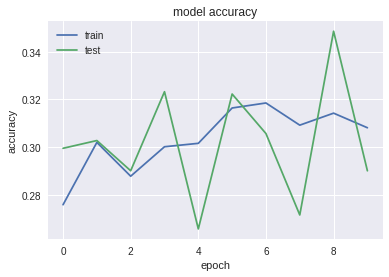

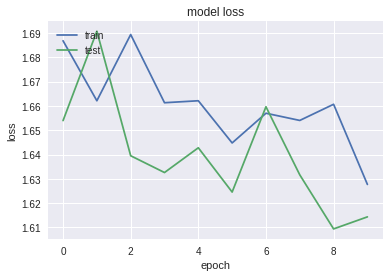

In [15]:
tr_ac = np.load('temp_32_att_fc/train_accuracy.npy')
tr_lo = np.load('temp_32_att_fc/train_loss.npy')
te_ac = np.load('temp_32_att_fc/test_accuracy.npy')
te_lo = np.load('temp_32_att_fc/test_loss.npy')

# summarize history for accuracy
plt.plot(np.arange(len(tr_ac)), tr_ac)
plt.plot(np.arange(len(te_ac)), te_ac)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(np.arange(len(tr_lo)), tr_lo)
plt.plot(np.arange(len(te_lo)), te_lo)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()